In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Get the column names and types of each table
inspector = inspect(engine)

measurement_columns = inspector.get_columns('measurement')
print('MEASUREMENT TABLE')
for column in measurement_columns:
    print(column["name"], column["type"])
    
print()

print('STATION TABLE')
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])

MEASUREMENT TABLE
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

STATION TABLE
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

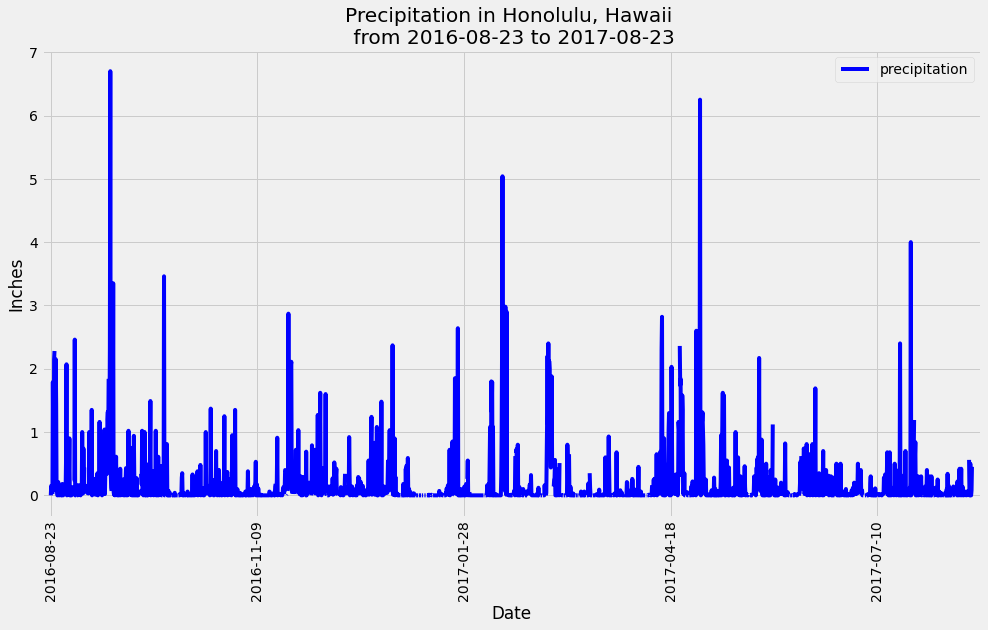

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
qry_last_row = 'SELECT date FROM measurement m ORDER BY m.id DESC LIMIT 1'
last_row = engine.execute(qry_last_row).fetchall()
last_date_point = last_row[0][0] # the last date in the data set

last_date = dt.datetime.strptime(last_date_point,'%Y-%m-%d') # convert the last date from a string to a datetime object
date_one_year_ago = dt.date(last_date.year - 1, last_date.month, last_date.day)

# Perform a query to retrieve the data and precipitation scores
precipitation_results = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= date_one_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data = pd.DataFrame(precipitation_results,columns=['date','precipitation'])
precipitation_data = precipitation_data.set_index("date")

# Use Pandas Plotting with Matplotlib to plot the data
Precipitation_Analysis_Plot = precipitation_data.plot(use_index=True, y='precipitation', figsize=(15,8),color='Blue', 
                                                      linewidth=4)
Precipitation_Analysis_Plot.set_title(f"Precipitation in Honolulu, Hawaii \n from {date_one_year_ago} to {last_date_point}")
Precipitation_Analysis_Plot.set_xlabel("Date")
Precipitation_Analysis_Plot.set_ylabel("Inches")
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.margins(x=0.01)
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(func.count(Station.id)).all()
print(f'the number of stations available is {number_of_stations[0][0]}.')

the number of stations available is 9.


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

query = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

stations_by_activity = pd.DataFrame(query, columns=['station','station_count'])
stations_by_activity

,station,station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [15]:
# Most active station
most_active_station = stations_by_activity.head(1)
most_active_station

,station,station_count
0,USC00519281,2772


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station_id = most_active_station['station'][0]

highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station==most_active_station_id).all()
print(f'the highest temperature for {most_active_station_id} is {highest_temp[0][0]} F')

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station==most_active_station_id).all()
print(f'the lowest temperature for {most_active_station_id} is {lowest_temp[0][0]} F')

average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==most_active_station_id).all()
print(f'the average temperature for {most_active_station_id} is {average_temp[0][0]} F')

the highest temperature for USC00519281 is 85.0 F
the lowest temperature for USC00519281 is 54.0 F
the average temperature for USC00519281 is 71.66378066378067 F


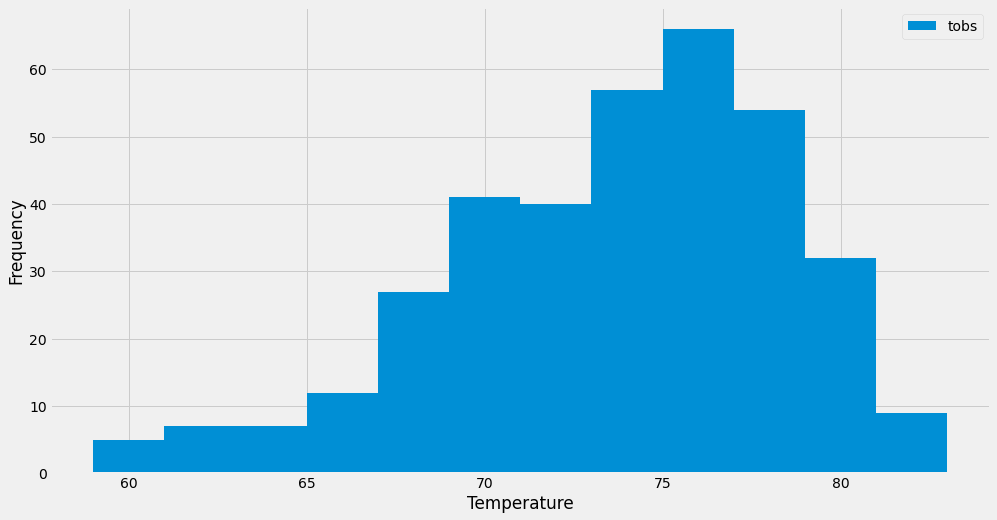

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Step 1: Find the last date mentioned for station 'USC00519281'
qry_last_row = f"SELECT date, tobs FROM measurement m WHERE m.station=='{most_active_station_id}' ORDER BY m.id DESC LIMIT 1"
last_row = engine.execute(qry_last_row).fetchall()
last_date_point = last_row[0][0] # the last date in the data set
last_date_point

# Step 2: Find the date one year ago for station 'USC00519281'
last_date = dt.datetime.strptime(last_date_point,'%Y-%m-%d') # convert the last date from a string to a datetime object
date_one_year_ago = dt.date(last_date.year - 1, last_date.month, last_date.day)

# Step 3: Query the results
tobs_results = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.date >= date_one_year_ago, Measurement.station==most_active_station_id).\
order_by(Measurement.date.asc()).all()

# Step 4: Display the results in a DataFrame
df = pd.DataFrame(tobs_results,columns=['date','tobs'])
df = df.set_index('date')

# Step 5: Show the results in a histogram
temperature_histogram = df.plot.hist(bins=12,figsize=(15,8))
temperature_histogram.set_xlabel("Temperature")
plt.show()

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-04-02', '2017-04-10'))

[(67.0, 74.29824561403508, 79.0)]


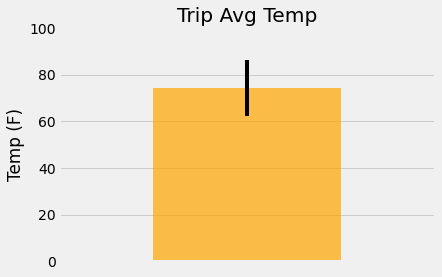

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Get the measurements
results = calc_temps('2017-04-02', '2017-04-10')

# Assign them to a dictionary then convert them to a DataFrame
results_dict = {"tmin":results[0][0],
               "tavg":results[0][1],
               "tmax":results[0][2]
               }
results_df = pd.DataFrame(results_dict, index=[0])

# Plot the graph
Trip_Avg_Temp_graph = results_df.plot.bar(y='tavg', yerr=results_df['tmax']-results_df['tmin'],align='center', 
                                         color="Orange", legend=None, alpha=0.7, ylabel="Temp (F)", title="Trip Avg Temp")
x_axis = Trip_Avg_Temp_graph.axes.get_xaxis()
x_axis.set_visible(False)
plt.ylim(0,100)

plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Query the total rainfall for the previous years dates
total_rainfall = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude,
                              Station.longitude, Station.elevation).filter(Measurement.date >= '2017-04-02').\
                              filter(Measurement.date <= '2017-04-10').group_by(Measurement.station).\
                              order_by(func.sum(Measurement.prcp)).join(Station,Measurement.station==Station.station).all()

total_rainfall_df = pd.DataFrame(total_rainfall, columns = ["station", "total rainfall", "name",
                                                            "latitude", "longitude", "elevation"])
# Display the data
total_rainfall_df

,station,total rainfall,name,latitude,longitude,elevation
0,USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9
1,USC00519397,0.00,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2,USC00519523,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,USC00514830,0.16,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00513117,0.17,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
5,USC00519281,0.52,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
6,USC00516128,0.70,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-04-02'
end_date = '2017-04-10'
# Use the start and end date to create a range of dates
start_date = dt.datetime.strptime(start_date,'%Y-%m-%d')
end_date = dt.datetime.strptime(end_date,'%Y-%m-%d')
holiday_period = pd.date_range(start_date,end_date)

holiday_period_list = []
for day in holiday_period: 
    holiday_period_list.append(day.strftime("%Y-%m-%d"))

# Stip off the year and save a list of %m-%d strings
holiday_date_list = []
for day in holiday_period: 
    d = day.strftime("%m-%d")
    holiday_date_list.append(d)
    
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for d in holiday_date_list:
    normals.append(daily_normals(d))
    
normals

[[(53.0, 71.82142857142857, 79.0)],
 [(55.0, 72.2280701754386, 78.0)],
 [(58.0, 72.01639344262296, 78.0)],
 [(61.0, 72.28813559322033, 80.0)],
 [(67.0, 71.57142857142857, 77.0)],
 [(63.0, 71.10526315789474, 78.0)],
 [(66.0, 72.10526315789474, 77.0)],
 [(62.0, 71.6140350877193, 78.0)],
 [(64.0, 71.40350877192982, 79.0)]]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_daily_normals_list = []

i=0

for i in range(i,len(normals)):
        daily_normal = {"date":holiday_period_list[i], "tmin":normals[i][0][0], "tavg":normals[i][0][1], "tmax": normals[i][0][2]}
        trip_daily_normals_list.append(daily_normal)
        
daily_normals_df = pd.DataFrame(trip_daily_normals_list).set_index("date")
daily_normals_df

,tmin,tavg,tmax
date,,,
2017-04-02,53.0,71.821429,79.0
2017-04-03,55.0,72.228070,78.0
2017-04-04,58.0,72.016393,78.0
2017-04-05,61.0,72.288136,80.0
2017-04-06,67.0,71.571429,77.0
2017-04-07,63.0,71.105263,78.0
2017-04-08,66.0,72.105263,77.0
2017-04-09,62.0,71.614035,78.0
2017-04-10,64.0,71.403509,79.0


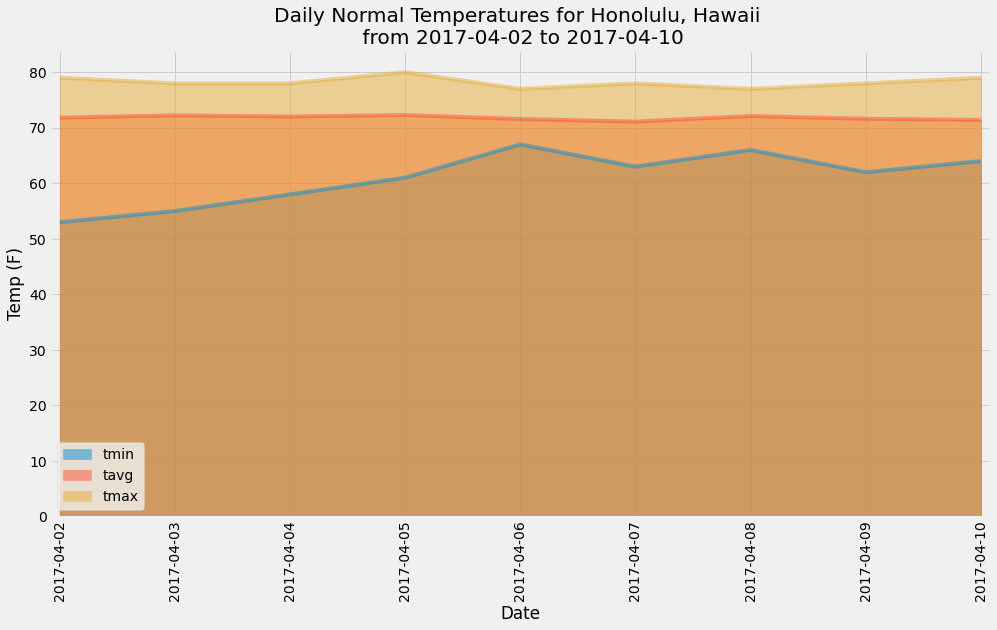

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_plot = daily_normals_df.plot.area(y=['tmin','tavg','tmax'], stacked=False, figsize=(15,8))
plt.xticks(rotation=90)
plt.title(f"Daily Normal Temperatures for Honolulu, Hawaii \n from {daily_normals_df.index[0]} to {daily_normals_df.index[8]}")
daily_normals_plot.margins(x=0.01)
plt.xlabel(xlabel="Date")
plt.ylabel(ylabel="Temp (F)")
plt.legend(loc="lower left")
plt.show()